# Case Study 2 - AISC2007 - Deep Learning 01
1. Dorai Charan Simha Muthineni - 500185125<br>
2. Krishna Vamsi Vanga - 500187921<br>
3. Naveen Kumar Pathi - 500187816<br>
4. Sai Chand Devarapalli - 500192020<br>
5. Venkatesh Policherla - 500194692<br>

## Introduction

This notebook presents a Convolutional Neural Networks (CNNs) based Deep Learning (DL) approach to classifying the breed (4 different breeds) of sheep based upon imagery which exhibited a mean classification accuracy of 90.35% across 6 re-runs of the kernel.


The notebook follows a workflow with 5 clear stages:

**1) Data Preparation**

**2) Training/Testing Dataset Splitting**

**3) Model Definition**

**4) Model Training**

**5) Model Testing & Evaluation**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# also load the following for this project
from collections import Counter
import random  # import random library
import PIL  # import Pillow library
from PIL import Image  # import Image functionality
import torch  # import pytorch
from torch import nn
from sklearn import metrics  # import evaluation metrics


# import seaborn and matplotlib.pyplot for data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
image_dir = []
import os
for dirname, _, filenames in os.walk('/kaggle/input/sheep-breed-classification/SheepFaceImages/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        image_dir.append(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Stage 1: Data Preparation

The first stage involves preparing the data for the subsequent steps. Specifically, this involves first extracting & preprocessing the data from its raw format into a format that can be understood by a machine (step 1.1), and then shuffling and tensorizing the data (step 1.2).

#### 1.1 Data Extraction & Preprocessing

The first step involves extracting the data from the directory and preprocessing it so that it can be appropriately understood by a machine. With this in mind, the images within the directory are iterated over, with the 'images' variable being populated with the imagery data, and the 'labels' variable with the classification label.

Specifically at each iteration, the image is first converted to a 3D numpy array, and each value is divided by 255 which serves to scale the data and thus accelerate the calculations associated with DL, whilst the value appended to the 'labels' variable is encoded with a value that corresponds to the sheep breed classification.

Additionally, one of the 1680 images was of different size (all others were 181 x 156 x 3). In this case the image was discarded.

In [2]:
images = []  # variable to store the image data as 3D numpy arrays
labels = []  # variable to store the label of each image
unique_labels = list(set([str(directory[57:].split('/')[0]) for directory in image_dir]))  # unique labels
for d in image_dir:  # iterate over file directory
    if np.asarray(Image.open(d)).shape == (181, 156, 3):  # serves to remove different sized images
        images.append(np.asarray(Image.open(d)) / 255)  # append images as scaled 3D numpy arrays
        labels.append(unique_labels.index(d[57:].split('/')[0]))  # append classifications as encoded labels

#### 1.2 Data shuffling and Tensorization

The second step of stage 1 involves shuffling and tensorizing the data. The shuffling is done using the function 'shuffle_data()', and is required in order to make sure that the training and testing sets (discussed later) both contain a fairly even split of all four sheep types. The tensorization is done using the 'tensorize_data()' function, which converts the x values into 3D tensors of type 'float', and the y values into tensors of type 'long'.

In [3]:
# a function that will shuffle the data
def shuffle_data(x_vals, y_vals):

    # convert the x and y values to tuples, and then shuffle it to randomise the order of variables
    data = [(x, y) for x, y in zip(x_vals, y_vals)]
    random.shuffle(data)
    new_x_vals, new_y_vals = zip(*data)
    
    return list(new_x_vals), list(new_y_vals)

# a function to tensorize the data
def tensorize_data(x_vals, y_vals):
    
    x_tensor = []
    y_tensor = []
    for x, y in zip(x_vals, y_vals):
        x_tensor.append(torch.from_numpy(x).float())
        y_tensor.append(torch.from_numpy(np.array(y)).long())
                
    return x_tensor, y_tensor

In [4]:
# shuffle the data
x_values, y_values = shuffle_data(images, labels)

# tensorize the data
x_tensor, y_tensor = tensorize_data(x_values, y_values)

### Stage 2: Training/Testing Dataset Splitting

The second stage involves splitting the data into training/testing datasets. The former is used to train the model by enabling it to learn from the data and adjust its parameters in order to generalize effectively, whilst the latter is used in order to provide a final evaluation on the model's performance.

The x and y tensors are split by index, whereby the training sets (x_train and y_train) variables represent the first 1400 values within the x_tensor and y_tensor variables, and the testing sets (x_test and y_test) represent the last 279 values within the x_tensor and y_tensor variables. Since the ordering of values were shuffled in Stage 1 (using the 'shuffle_data()' function), the training and testing sets should both contain a fairly even split of x/y values corresponding to each of the 4 sheep breeds.

In [5]:
# split the train/test split
split = 279 # define the index upon which to split
x_train = x_tensor[:-split]
y_train = y_tensor[:-split]
x_test = x_tensor[-split:]
y_test = y_tensor[-split:]
print(len(x_train), len(x_test))

1400 279


### Stage 3: Model Definition

Following the splitting of the training/testing datasets, the model is then defined. The model is built in PyTorch, a DL framework, and is composed of a CNN layer and an MLP fully connected layer. 

The CNN layer applies (i) a 2D convolution over an input signal (nn.Conv2d()), (ii) batch normalization over the resulting 4D input (nn.BatchNorm2d()), (iii) the ReLU non-linear unit function elementwise over the output of the 2D convolution and batch normalization, and (iv) a 2D max pooling on the output of the three previous components.
    
The MLP fully connected layer takes the flattened CNN layer output and feeds it through an MLP which feaures three hidden layers of width 800, 200 and 75 (each featuring a ReLU unit function) which map the 5390 inputs to 4 outputs which correspond to the four sheep breeds.

In [6]:
# define our sheep classification model
class SheepClassifier(nn.Module):   
    def __init__(self):
        super(SheepClassifier, self).__init__()

        # the CNN component
        self.cnn_component = nn.Sequential(
            nn.Conv2d(181, 70, kernel_size=2),  #  2D convolution
            nn.BatchNorm2d(70),  # batch normalization
            nn.ReLU(inplace=True),  # ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),  # 2D max pooling
        )

        # the MLP fully connected layer
        self.cnn_output_linear = nn.Sequential(
            nn.Dropout(0.02),
            nn.Linear(70 * 77 * 1, 800),
            nn.ReLU(),
            nn.Dropout(0.02),
            nn.Linear(800, 200),
            nn.ReLU(),
            nn.Dropout(0.02),
            nn.Linear(200, 75),
            nn.ReLU(),
            nn.Linear(75, 4)
        )

    # defining the forward pass    
    def forward(self, x):
        
        # pass through the CNN component
        cnn_output = self.cnn_component(x)
        
        # flatten outputs
        cnn_output_reshaped = cnn_output.view(cnn_output.shape[0], cnn_output.shape[1]
                                              * cnn_output.shape[2] * cnn_output.shape[3])
        
        # pass flattened output through the MLP fully connected layer
        output = self.cnn_output_linear(cnn_output_reshaped)
        
        return output
    
sheep_classifier = SheepClassifier()  # define the model
print(sheep_classifier)  # print the model to summarise it

SheepClassifier(
  (cnn_component): Sequential(
    (0): Conv2d(181, 70, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_output_linear): Sequential(
    (0): Dropout(p=0.02, inplace=False)
    (1): Linear(in_features=5390, out_features=800, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.02, inplace=False)
    (4): Linear(in_features=800, out_features=200, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.02, inplace=False)
    (7): Linear(in_features=200, out_features=75, bias=True)
    (8): ReLU()
    (9): Linear(in_features=75, out_features=4, bias=True)
  )
)


### Stage 4: Model Training

Stage 4 involves training the model by (i) feeding it batches of training data, (ii) evaluating its output against the corresponding labels and (iii) backpropagating through the model and updating parameters in order to optimize performance.

The following hyperparameters were used:
* Number of Epochs: 100
* Loss Function: Cross Entropy Loss
* Optimizer: Adam's Optimizer
* Learning rate: 0.000025

A validation set is also used in order to check for overfitting.

In [7]:
loss_fn = nn.CrossEntropyLoss()  # loss function
optimizer = torch.optim.Adam(sheep_classifier.parameters(), lr=0.000025)  # optimizer
epochs = 100  # number of times we repeat the training process
batch_size = 50  # batch number

x_val, y_val = x_train[-batch_size:], y_train[-batch_size:]  # validation set 
x_train, y_train = x_train[:-batch_size], y_train[:-batch_size]  # new training set

# form validation batch in advance
val_x_batch = None
val_y_batch = None
for v in range(batch_size):
    if v % batch_size == 0:
        val_x_batch = torch.unsqueeze(x_val[v], dim=0)
        val_y_batch = torch.unsqueeze(y_val[v], dim=0)
    else:
        val_x_batch = torch.cat((val_x_batch, torch.unsqueeze(x_val[v], dim=0)), dim=0)
        val_y_batch = torch.cat((val_y_batch, torch.unsqueeze(y_val[v], dim=0)), dim=0)

# now start the training process
for i in range(epochs):
    x_batch = None
    y_batch = None
    for z in range(len(x_train)):
        # batching done within the training process
        if z % batch_size == 0:
            x_batch = torch.unsqueeze(x_train[z], dim=0)
            y_batch = torch.unsqueeze(y_train[z], dim=0)
        else:
            x_batch = torch.cat((x_batch, torch.unsqueeze(x_train[z], dim=0)), dim=0)
            y_batch = torch.cat((y_batch, torch.unsqueeze(y_train[z], dim=0)), dim=0)            
        
        if x_batch.shape[0] == batch_size:
            preds = sheep_classifier(x_batch)  # feed batch to the model
            single_loss = loss_fn(preds, y_batch)  # calculate loss from the batch
            
            # validation set evaluation
            with torch.no_grad():  # disable autograd engine
                val_preds = sheep_classifier(val_x_batch)  # feed val batch to the model
                val_loss = loss_fn(val_preds, val_y_batch)  # calculate loss from the val batch

            optimizer.zero_grad()  # zero the gradients
            single_loss.backward()  # backpropagate through the model
            optimizer.step()  # update parameters
        
    if i%5 == 0:
        print(f'epoch: {i:5} training loss: {single_loss.item():10.8f} validation loss: {val_loss.item():10.8f}')

epoch:     0 training loss: 1.21026301 validation loss: 1.12060595
epoch:     5 training loss: 0.57683688 validation loss: 0.65550476
epoch:    10 training loss: 0.27591032 validation loss: 0.53950548
epoch:    15 training loss: 0.12563725 validation loss: 0.52040201
epoch:    20 training loss: 0.06381271 validation loss: 0.53562957
epoch:    25 training loss: 0.02911971 validation loss: 0.64726555
epoch:    30 training loss: 0.01833402 validation loss: 0.66226041
epoch:    35 training loss: 0.01307509 validation loss: 0.64855582
epoch:    40 training loss: 0.01436068 validation loss: 0.51266867
epoch:    45 training loss: 0.02560268 validation loss: 0.65054816
epoch:    50 training loss: 0.00784900 validation loss: 0.84781146
epoch:    55 training loss: 0.00251285 validation loss: 0.68153071
epoch:    60 training loss: 0.00216499 validation loss: 0.70186663
epoch:    65 training loss: 0.00173663 validation loss: 0.67204988
epoch:    70 training loss: 0.00119157 validation loss: 0.6829

### Stage 5: Model Testing & Evaluation

With the model being fully trained, the model is then fed unseen testing data and its performance evaluated.

The testing data is first concatenated into batches in order to feed the model all the data at once, as such:

In [8]:
# change the model into its evaluation setting
sheep_classifier.eval()

# concatenate along new first dimension
x_test_stack = None

# x_test_stack
for i in enumerate(x_test):
    if x_test_stack == None:
        x_test_stack = torch.unsqueeze(i[1], dim=0)
    else:
        x_test_stack = torch.cat((x_test_stack, torch.unsqueeze(i[1], dim=0)), dim=0)

# y_test_stack
y_test_stack = None

# populate the y_test_stack variable
for z in enumerate(y_test):
    if y_test_stack == None:
        y_test_stack = torch.unsqueeze(z[1], dim=0)
    else:
        y_test_stack = torch.cat((y_test_stack, torch.unsqueeze(z[1], dim=0)), dim=0)

The model is then fed the stacked (concatenated) testing data, and the model outputs are compared to the actual labels using an accuracy score:

In [9]:
model_preds = sheep_classifier(x_test_stack)  # input testing data
model_preds = np.argmax(model_preds.detach().numpy(), axis=1)
accuracy = metrics.accuracy_score(y_test_stack, model_preds)  # check accuracy
print(f'Overall testing accuracy is {round((accuracy * 100), 2)}% (2 d.p)')

Overall testing accuracy is 90.32% (2 d.p)


From 6 re-runs, the mean accuracy score was 90.35% with the scores ranging from 87.81-91.40%. However, subsequent re-runs of this kernel by other users may yield scores outside of this range due to (i) each re-run producing a different split of training/testing set images due to the shuffling function, and (ii) the model's parameters being randomly initialised upon definition.

The function below plots 6 randomly selected images of sheep within the testing set, as well as the model's prediction and the correct label.

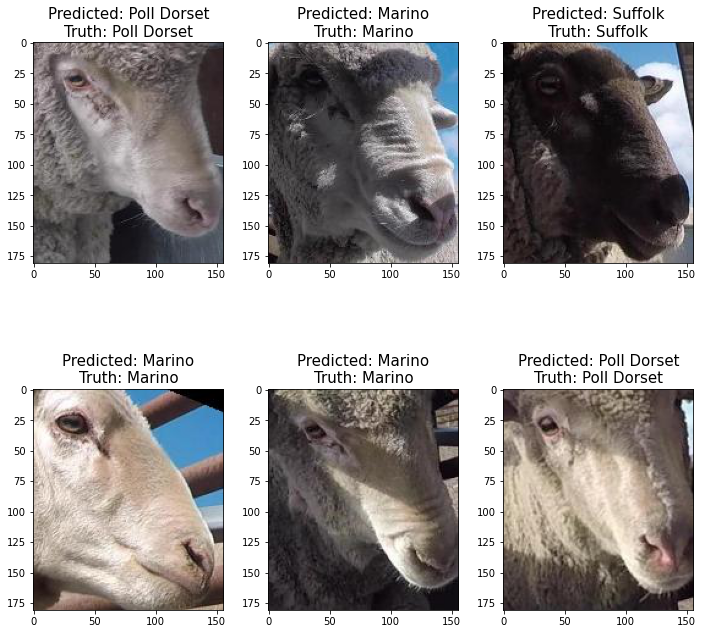

In [10]:
# a function to present images of sheep within the testing set as well as 
# the model's prediction and the correct label
def result_presentation(x_test, y_test, prediction, labels):
    
    ran = random.sample(range(0, x_test.shape[0]), 6)
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(2, 3, figsize=(10,10))
    
    ax[0, 0].imshow(x_test[ran[0]].numpy())
    ax[0, 0].set_title("Predicted: " + labels[prediction[ran[0]]] + 
                       "\nTruth: " + labels[y_test[ran[0]]], fontsize=15)

    ax[0, 1].imshow(x_test[ran[1]].numpy())
    ax[0, 1].set_title("Predicted: " + labels[prediction[ran[1]]] + 
                       "\nTruth: " + labels[y_test[ran[1]]], fontsize=15)
    
    ax[0, 2].imshow(x_test[ran[2]].numpy())
    ax[0, 2].set_title("Predicted: " + labels[prediction[ran[2]]] + 
                       "\nTruth: " + labels[y_test[ran[2]]], fontsize=15)
    
    ax[1, 0].imshow(x_test[ran[3]].numpy())
    ax[1, 0].set_title("Predicted: " + labels[prediction[ran[3]]] + 
                       "\nTruth: " + labels[y_test[ran[3]]], fontsize=15)
    
    ax[1, 1].imshow(x_test[ran[4]].numpy())
    ax[1, 1].set_title("Predicted: " + labels[prediction[ran[4]]] + 
                       "\nTruth: " + labels[y_test[ran[4]]], fontsize=15)
    
    ax[1, 2].imshow(x_test[ran[5]].numpy())
    ax[1, 2].set_title("Predicted: " + labels[prediction[ran[5]]] + 
                       "\nTruth: " + labels[y_test[ran[5]]], fontsize=15)
    
    f.tight_layout(pad=1.5)
    
    return

# call the function
result_presentation(x_test_stack, y_test_stack, model_preds, unique_labels)

In order to better understand the successes and limitations of this model, the accuracy by sheep breed was calculated and plotted as a bar chart in order to see how/if the model's accuracy at classifying all four different sheep breeds is consistent across breeds, or whether it displays better performance with some as opposed to others. The code is outlined below:

Text(0.5, 1.0, 'A Barplot comparing the model classification \naccuracy by sheep breed')

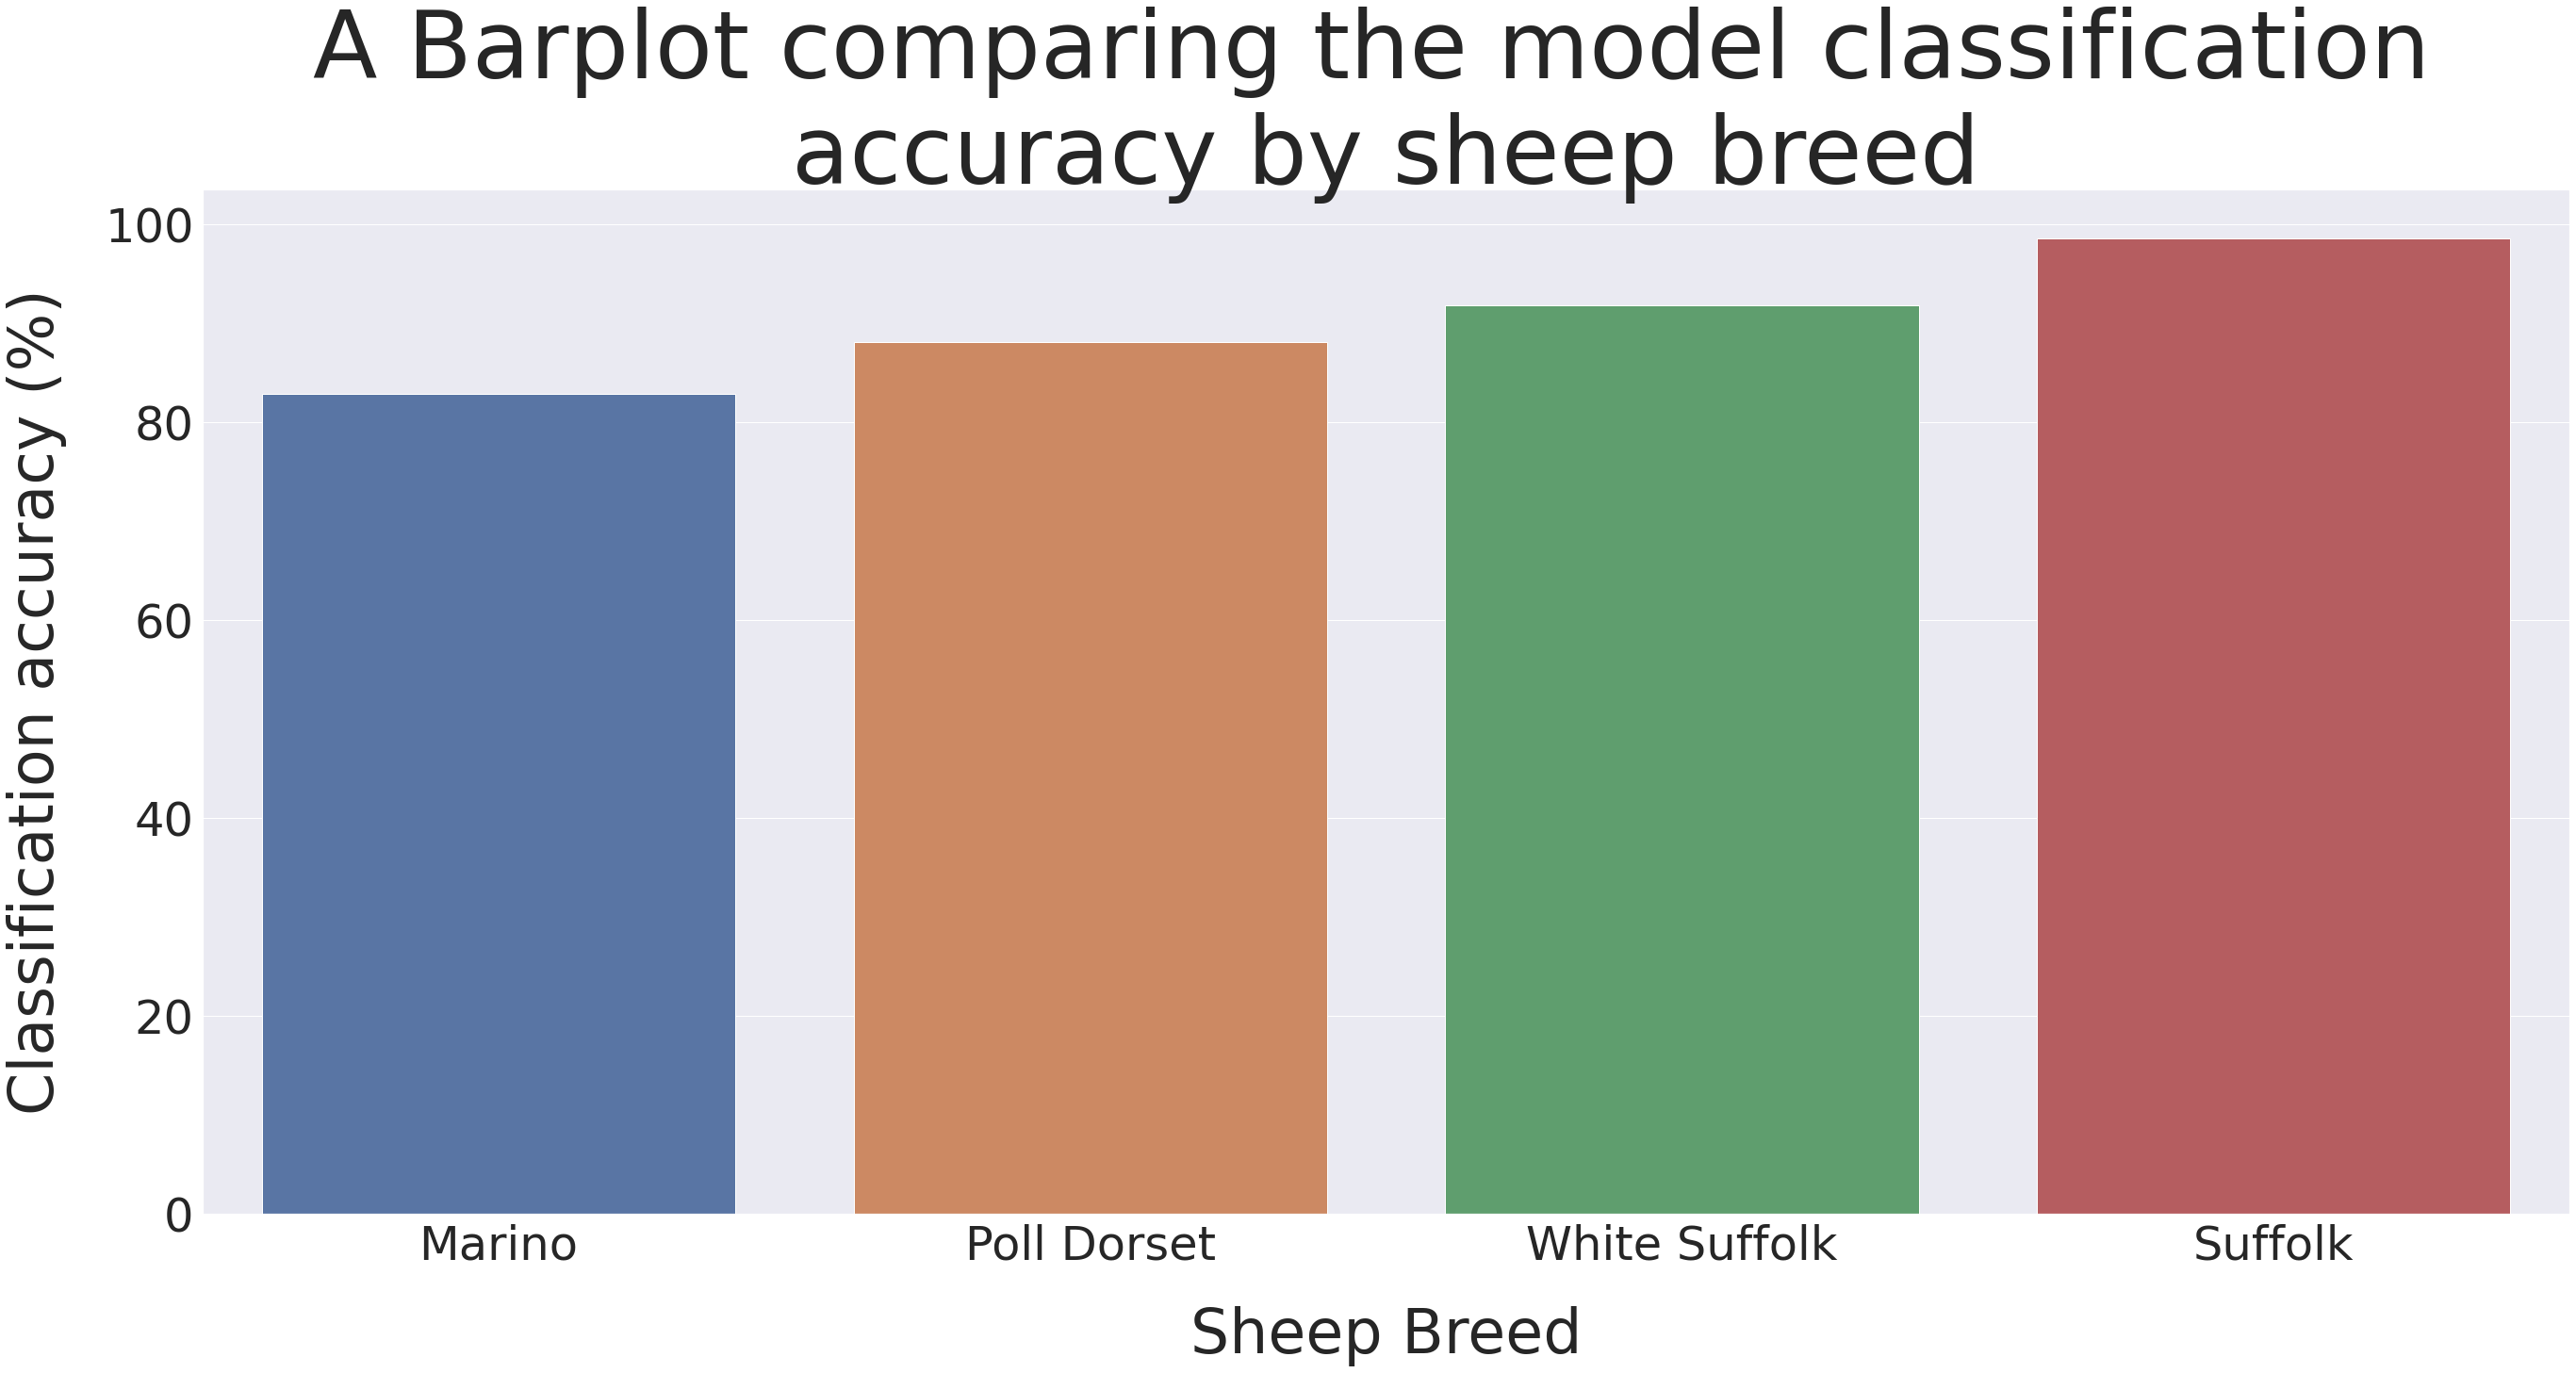

In [11]:
# define a function that calculates the accuracy of each sheep breed
def accuracy_by_breed(y_test, predictions, label):
    
    correct = 0
    labels = 0
    for truth, predicted in zip(y_test.tolist(), predictions):
        #print(truth, predicted)
        if truth == label:
            labels += 1
        
        if truth == label and predicted == label:
            correct += 1
                                    
    return (correct / labels) * 100 

# determine the accuracy of testing predictions by sheep breed
label_0 = accuracy_by_breed(y_test_stack, model_preds, 0)
label_1 = accuracy_by_breed(y_test_stack, model_preds, 1)
label_2 = accuracy_by_breed(y_test_stack, model_preds, 2)
label_3 = accuracy_by_breed(y_test_stack, model_preds, 3)

# plot as a barchart
sns.set(rc={'figure.figsize': (45.0, 20.0)})
sns.set_context("notebook", font_scale=4.5, rc={"lines.linewidth": 0.5})
ax = sns.barplot(x=unique_labels,
                 y=[label_0, label_1, label_2, label_3])
ax.set_ylabel('Classification accuracy (%)', labelpad=40, fontsize=65)
ax.set_xlabel('Sheep Breed', labelpad=40, fontsize=65)
plt.title("A Barplot comparing the model classification \naccuracy by sheep breed", fontsize=100)

Generally from re-runs, the model appears to perform better with classifying both the Suffolk and White Suffolk sheep breeds, whilst it struggles more with both the Poll Dorset breed and particularly the Marino breed. However, the performance of the model across the sheep breeds may vary in subsequent re-runs from other users.

## Conclusion

Overall, this deep learning CNN based model appears competent at classifying sheep breeds with a mean accuracy score of 90.35% and accuracy values ranging from 87.81-91.40%.